# Probabilistic classifier of texts into spam / ham

## Intro

Here is a classical "complete the notebook" assignment. 

You can run all the cells in the notebook, and some of them you have to complete. 

The code you have to complete is marked with `#TODO` comments. The cells containing such code also contain assertions that you should fulfill. 

If the cells produce no errors, you can be pretty sure you do everything OK. 

Let's try it!

In [21]:
def square_root(x):
    """ This is a function that takes a non-negative numeric argument x and produces its square root. """
    # TODO: calculate the square root of x and put it into the y variable instead of None. 
    # If you are not sure, have a look on the list of Python basic operators
    # https://www.tutorialspoint.com/python/python_basic_operators.htm
    y = x**0.5
    return y

assert square_root(144) == 12

Now that you understand the format, let's have look at a [Naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) of short messages into spam and not-spam.

The main idea behind it is that $$P(spam|text) = \frac{P(spam)P(text|spam)}{P(text)}$$

You will have to implement this formula along with some hacks to make its application more robust.

![](https://pics.me.me/suppose-you-have-one-rabbit-now-suppose-someone-gives-you-21826742.png)

## Loading the data

The cell below loads the file with messages. 

If you run this notebook locally on Windows, you have to download the file manually. 

In [22]:
# !wget https://raw.githubusercontent.com/avidale/ps4ds2019/master/homework/week1/spam_classifier/SMSSpamCollection # skipped this to use url

The following cell imports some Python libraries. It is possible that you have some of them not installed (namely, `pandas`). In this case, you have to install them using package manager from command line. The command would look like `pip install pandas` or `conda install pandas`.

If you run this notebook from Google Colab, then the libraries are already installed

In [23]:
# load some useful Python libratries

import pandas as pd # the library for working with data tables
import re
from collections import Counter # a class for counting objects (words and text labels, in our case)

In [24]:
# load the data from disk to a tabular format, and give readable names to its columns
SMSSpamCollection_url = 'https://raw.githubusercontent.com/avidale/ps4ds2019/master/homework/week1/spam_classifier/SMSSpamCollection'
data = pd.read_csv(SMSSpamCollection_url, sep='\t', header=None)
data.columns = ['target', 'text']

In this dataset, "ham" is a good text, and "spam" is, well, spam. 

In [25]:
# enable pandas to display large texts and look into our data
pd.options.display.max_colwidth = 300

print(data.shape) # number of rows and columns
data.head(5)

(5572, 2)


,target,text
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


## Preprocessing the data

In a minute we will have to estimate probabilites of different texts. 

We could use *language models* using e.g. n-grams or recurrent neural networks, to calculate probability of original texts. 

But for our problem, it will be sufficient to represent each text with the set of words (and other symbols) that occur in it. This representation ignores word order and number of words.

That is, we will not make difference between texts 

> this one is a long message. 

and 

> this message is a long long long long long long one.

Both will be represented as a set of tokens:

In [26]:
def get_words(text):
    """ This function converts the given text into an unordered and uncounted bag of words. """
    return set(re.split('\W+', text)).difference({''})

# just an example
get_words("this message is a long, long, long, long long long one.")

{'a', 'is', 'long', 'message', 'one', 'this'}

This simplified approach will allow us to train the probabilistic model of texts using a modest amount of data.

In [27]:
# apply this logic to texts of all messages
bags_of_words = [get_words(text) for text in data.text] 

To evaluate how well our model classifies messages, let's train it on the first 3000 texts, and measure accuracy on the rest.

In [28]:
n_train = 3000
train_x, test_x, train_y, test_y = bags_of_words[:n_train], bags_of_words[n_train:], data.target[:n_train], data.target[n_train:] #This is not stratified 

## The basic classifier

In the cell below, we will count occurences of words under different labels.

We are going to use `Counter` objects. If you are not sure how they work, please look at [the documentation](https://docs.python.org/3.6/library/collections.html#collections.Counter). 

In [29]:
# this counter will keep the number of spam and ham texts
label_counter = Counter()

# these counters will keep the frequency of each word in ham and spam texts
word_counters = {
    'spam': Counter(), 
    'ham': Counter()
}

all_words = set()

for label, words in zip(train_y, train_x):
    all_words.update(words)
    # TODO: use the `update` methods of all 3 counters, to calculate total number of 
    label_counter.update([label])
    word_counters[label].update(words)
    
assert label_counter['spam'] == 409
assert word_counters['ham']['hello'] >= 2

Now let's calculate different probabilities of words, texts, and labels for our classifier

In [30]:
def prior_probability_of_label(label):
    """ This function evaluates probability of the given label (it can be 'spam' or 'ham'), using the counters. """
    # TODO: calculate and return this probability as ratio of number of texts with this labels to number all texts
    return label_counter[label]/sum(label_counter.values())

assert round(prior_probability_of_label('spam'), 2) == 0.14
assert round(prior_probability_of_label('ham'), 2) == 0.86

In [31]:

def word_probability_given_label(word, label):
    """ This function calculates probability of a word occurence in text, conditional on the label of this text. """
    # TODO: calculate and return this probability 
    # as ratio of number of texts with this word and label to number of texts with this label
    return word_counters[label][word]/label_counter[label]

assert round(word_probability_given_label("99", "spam"), 3) == 0.002

Here we encounter the first practical problem: some words have never occurred in our training data. 

But they can probably occur in the texts to which our model will be applied in the future. 

To assign a non-zero probability to such texts, we can slightly modify the `word_probability_given_label`. For example, instead of original estimate, 

$$\hat{p}(word|label) = \frac{count(word, label)}{count(label)}$$

we could use a "smoothed" version

$$\hat{p}(word|label) = \frac{count(word, label) + \alpha\times p}{count(label) + p}$$

where $alpha\in(0, 1)$ is the anchor probability towards which we move our estimate, and $p$ is the step size towards this anchor. 

Values like $p=0.1$ and $\alpha=10^{-3}$ would do.  

In [32]:
# TODO: modify the `word_probability_given_label` function, by moving each probability towards a small positive constant

def word_probability_given_label(word, label, p = 0.1 ,alpha = 0.001):
    """ This function calculates probability of a word occurence in text, conditional on the label of this text."""
    return (word_counters[label][word]+p*alpha)/(label_counter[label]+p)

assert word_probability_given_label("999", "spam") > 0
assert word_probability_given_label("999", "spam") < 0.005

Now we can move from words to texts. 

Here is where we apply our naive assumption that occurrences of each word are independent:
$$ P(text|label) = \prod_{word \in text} P(word|label) \times \prod_{word \notin text} (1-P(word|label)) $$

In [33]:
def text_probability_given_label(text, label):
    """ This function calculates probability of the text conditional on its label. """
    if isinstance(text, str):
        text = get_words(text)
    probability = 1.0
    # TODO: calculate the probability of text given label. 
    # use a function defined above and the naive assumption of word independence
    for word in all_words:
        p = word_probability_given_label(word, label)
        if word in text:
            probability *= p
        else:
            probability *= (1-p)
    return probability

greeting1 = 'hello how are you'
greeting2 = 'hello teacher how are you'

assert text_probability_given_label(greeting1, 'ham') > 0
assert text_probability_given_label(greeting1, 'ham') < 0.0001
assert text_probability_given_label(greeting2, 'ham') < text_probability_given_label(greeting1, 'ham')

Now you have all the components to compile your first probabilistic classifier!


Reminder of Bayes theorem:
$$\begin{aligned}
 Pr(Label|Text) &= \frac{Pr(Text\mid Label)\cdot Pr(Label)}{Pr(Text)} \\
                &= \frac{Pr(Text\mid Label)\cdot Pr(Label)}{Pr(Text \mid Label)\cdot Pr(Label) + Pr(Text \mid Label^{c})\cdot Pr(Label^{c})}
\end{aligned}
$$


In [34]:
def label_probability_given_text(text, label):
    """ This function calculates probability of the label (spam or ham) conditional on the text. """
    # TODO: calculate label probability conditional on text
    # use the Bayes rule and the functions defined above
    p_L = prior_probability_of_label(label)
    p = text_probability_given_label(text,label)
    if label == 'ham':
        p_c = text_probability_given_label(text,'spam')
    elif label == 'spam':
        p_c = text_probability_given_label(text,'ham')    
    return p*p_L/(p*p_L+p_c*(1-p_L))


text1 = 'hello how r you'
text2 = 'only today you can buy our book with 50% discount!'

assert label_probability_given_text(text1, 'ham') + label_probability_given_text(text1, 'spam') == 1.0
assert label_probability_given_text(text1, 'ham') > label_probability_given_text(text1, 'spam')
assert label_probability_given_text(text1, 'ham') > label_probability_given_text(text2, 'ham')

## Tuning the classifier

Now we have the classifier, but we don't know how well it works on the unseen data. 

Let's see what fraction of test messages are classified correctly:

In [35]:
threshold = 0.5
test_spam_probabilities = [label_probability_given_text(text, 'spam') for text in test_x]
test_predictions = ['spam' if spamness > threshold else 'ham' for spamness in test_spam_probabilities]

accuracy = sum(1 if pred == fact else 0 for pred, fact in zip(test_predictions, test_y)) / len(test_y)
print(accuracy)

assert accuracy > 0.9

0.9840590979782271


This is a good accuracy, but you can achieve better results by tuning the algorithm. 

What you can do:
* play with the different values of the threshold
* play with the regularization constants that you used in `word_probability_given_label`
* experiment with different implementations of `get_words` - e.g. ignore the word case, or use word lemmas
* use your imagination

Can you beat 99% accuracy?

Have a good time! (-:

## Quick EDA

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      2234
        spam       0.99      0.89      0.94       338

    accuracy                           0.98      2572
   macro avg       0.99      0.94      0.96      2572
weighted avg       0.98      0.98      0.98      2572



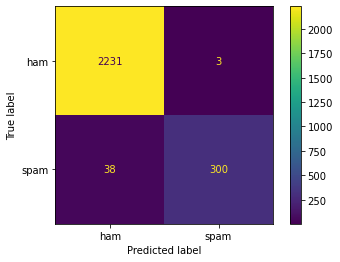

In [36]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns

cm = confusion_matrix(test_y, test_predictions)
CMDisp = ConfusionMatrixDisplay(cm, display_labels=['ham','spam'])
CMDisp.plot()
print(classification_report(test_y, test_predictions))

In [37]:
data.loc[(data['text'].str.contains('www.')) & (data.target == 'spam')]

,target,text
12,spam,"URGENT! You have won a 1 week FREE membership in our £100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18"
164,spam,-PLS STOP bootydelious (32/F) is inviting you to be her friend. Reply YES-434 or NO-434 See her: www.SMS.ac/u/bootydelious STOP? Send STOP FRND to 62468
191,spam,Are you unique enough? Find out from 30th August. www.areyouunique.co.uk
225,spam,"500 New Mobiles from 2004, MUST GO! Txt: NOKIA to No: 89545 & collect yours today!From ONLY £1 www.4-tc.biz 2optout 087187262701.50gbp/mtmsg18"
250,spam,Congratulations ur awarded 500 of CD vouchers or 125gift guaranteed & Free entry 2 100 wkly draw txt MUSIC to 87066 TnCs www.Ldew.com1win150ppmx3age16
...,...,...
5294,spam,XMAS iscoming & ur awarded either £500 CD gift vouchers & free entry 2 r £100 weekly draw txt MUSIC to 87066 TnC www.Ldew.com1win150ppmx3age16subscription
5378,spam,"Free entry to the gr8prizes wkly comp 4 a chance to win the latest Nokia 8800, PSP or £250 cash every wk.TXT GREAT to 80878 http//www.gr8prizes.com 08715705022"
5456,spam,For the most sparkling shopping breaks from 45 per person; call 0121 2025050 or visit www.shortbreaks.org.uk
5462,spam,Txt: CALL to No: 86888 & claim your reward of 3 hours talk time to use from your phone now! Subscribe6GBP/mnth inc 3hrs 16 stop?txtStop www.gamb.tv


In [38]:
import numpy as np 
test_data = data.iloc[n_train:].copy()
test_data['pred'] = test_predictions
test_data['prob_spam'] = test_spam_probabilities

test_data['prob_spam_round'] = np.round(test_spam_probabilities, 4)
with pd.option_context('display.max_rows', None):
    display(test_data.loc[test_data['target']!=test_data['pred']])


,target,text,pred,prob_spam,prob_spam_round
3132,spam,"LookAtMe!: Thanks for your purchase of a video clip from LookAtMe!, you've been charged 35p. Think you can do better? Why not send a video in a MMSto 32323.",ham,1.573164e-01,0.1573
3302,spam,RCT' THNQ Adrian for U text. Rgds Vatian,ham,4.747978e-08,0.0000
3360,spam,Sorry I missed your call let's talk when you have the time. I'm on 07090201529,ham,1.321439e-16,0.0000
3391,spam,Please CALL 08712402972 immediately as there is an urgent message waiting for you,ham,8.644385e-02,0.0864
3419,spam,LIFE has never been this much fun and great until you came in. You made it truly special for me. I won't forget you! enjoy @ one gbp/sms,ham,2.017001e-31,0.0000
3460,spam,Not heard from U4 a while. Call me now am here all night with just my knickers on. Make me beg for it like U did last time 01223585236 XX Luv Nikiyu4.net,ham,4.305110e-07,0.0000
3463,spam,Bloomberg -Message center +447797706009 Why wait? Apply for your future http://careers. bloomberg.com,ham,3.722596e-06,0.0000
3501,spam,Dorothy@kiefer.com (Bank of Granite issues Strong-Buy) EXPLOSIVE PICK FOR OUR MEMBERS *****UP OVER 300% *********** Nasdaq Symbol CDGT That is a $5.00 per..,ham,1.137744e-12,0.0000
3530,spam,"Xmas & New Years Eve tickets are now on sale from the club, during the day from 10am till 8pm, and on Thurs, Fri & Sat night this week. They're selling fast!",ham,1.195519e-08,0.0000
3574,spam,You won't believe it but it's true. It's Incredible Txts! Reply G now to learn truly amazing things that will blow your mind. From O2FWD only 18p/txt,ham,1.628844e-12,0.0000


Some conclusions from the above:
1. Phone numbers and money offers are much more frequent in spam
2. The length of the text could be a significant reason why some spam messages are misclassified: As the text has more words, there is a higher chance that 

$P(text|label)=P(word_1) \cdot P(word_2) \cdots P(word_n)\to 0$ 
        
two ways to tackle this issue are:
1. Trimming words from the data 
2. Tuning the models hyper-parameters, the anchor probability $(\alpha)$ and $p$ - the step size towards this anchor.   


## Feature engineering


We replace all different sets of numbers with a fixed set 

In [39]:
df = data.copy()

df['text'] = df['text'].str.replace('\d{4,}','set_of_numbers')
df['text'] = df['text'].str.replace('(?:[£$])[^\s]+','MMMM')

C:\Users\itay8\AppData\Local\Temp\ipykernel_22272\1969157810.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('\d{4,}','set_of_numbers')
C:\Users\itay8\AppData\Local\Temp\ipykernel_22272\1969157810.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('(?:[£$])[^\s]+','MMMM')


In [40]:
bags_of_words = [get_words(text) for text in df.text] 
n_train = 3000
train_x, test_x, train_y, test_y = bags_of_words[:n_train], bags_of_words[n_train:], df.target[:n_train], df.target[n_train:] #This is not stratified 

Creating counter again

In [41]:
# this counter will keep the number of spam and ham texts
label_counter = Counter()

# these counters will keep the frequency of each word in ham and spam texts
word_counters = {
    'spam': Counter(), 
    'ham': Counter()
}

all_words = set()

for label, words in zip(train_y, train_x):
    all_words.update(words)
    # TODO: use the `update` methods of all 3 counters, to calculate total number of 
    label_counter.update([label])
    word_counters[label].update(words)


In [42]:
threshold = 0.5
test_spam_probabilities = [label_probability_given_text(text, 'spam') for text in test_x]
test_predictions = ['spam' if spamness > threshold else 'ham' for spamness in test_spam_probabilities]

accuracy = sum(1 if pred == fact else 0 for pred, fact in zip(test_predictions, test_y)) / len(test_y)
print(accuracy)

0.9871695178849145


              precision    recall  f1-score   support

         ham       0.99      1.00      0.99      2234
        spam       0.99      0.91      0.95       338

    accuracy                           0.99      2572
   macro avg       0.99      0.95      0.97      2572
weighted avg       0.99      0.99      0.99      2572



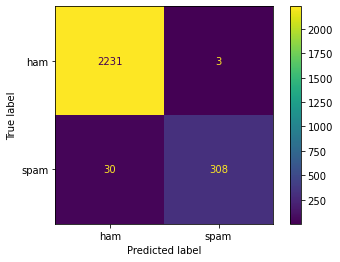

In [43]:
cm = confusion_matrix(test_y, test_predictions)
CMDisp = ConfusionMatrixDisplay(cm, display_labels=['ham','spam'])
CMDisp.plot()
print(classification_report(test_y, test_predictions))


### Feature engineering conclusion: 
We have lowered our false ham by 8 and our total model accurecy by 3%

Our issue with long text still exsits we will try to address this by tuning our `p_step` and `alpha`

### Greed tuning 
Recreating the function with parameters to tune.

In [44]:
def word_probability_given_label(word, label, p_step = 0.1 ,alpha = 0.001):
    """ This function calculates probability of a word occurence in text, conditional on the label of this text."""
    return (word_counters[label][word]+p_step*alpha)/(label_counter[label]+p_step)

def text_probability_given_label(text, label, p_step = 0.1 ,alpha = 0.001):
    """ This function calculates probability of the text conditional on its label. """
    if isinstance(text, str):
        text = get_words(text)
    probability = 1.0
    # TODO: calculate the probability of text given label. 
    # use a function defined above and the naive assumption of word independence
    for word in all_words:
        p = word_probability_given_label(word, label, p_step = p_step ,alpha = alpha)
        if word in text:
            probability *= p
        else:
            probability *= (1-p)
    return probability

def label_probability_given_text(text, label, p_step = 0.1 ,alpha = 0.001):
    """ This function calculates probability of the label (spam or ham) conditional on the text. """
    # TODO: calculate label probability conditional on text
    # use the Bayes rule and the functions defined above
    p_L = prior_probability_of_label(label)
    p = text_probability_given_label(text,label, p_step = p_step ,alpha = alpha)
    if label == 'ham':
        p_c = text_probability_given_label(text,'spam', p_step = p_step ,alpha = alpha)
    elif label == 'spam':
        p_c = text_probability_given_label(text,'ham', p_step = p_step ,alpha = alpha)    
    return p*p_L/(p*p_L+p_c*(1-p_L))

# def word_probability_given_label(word, label, p = 0.1 ,alpha = 0.0001):
#     """ This function calculates probability of a word occurence in text, conditional on the label of this text."""
#     return (word_counters[label][word]+p*alpha)/(label_counter[label]+p)

# def text_probability_given_label(text, label, p = 0.1, alpha= 0.0001):
#     """ This function calculates probability of the text conditional on its label. """
#     if isinstance(text, str):
#         text = get_words(text)
#     probability = 1.0
#     # TODO: calculate the probability of text given label. 
#     # use a function defined above and the naive assumption of word independence
#     for word in all_words:
#         p = word_probability_given_label(word, label, p = p, alpha=alpha)
#         if word in text:
#             probability *= p
#         else:
#             probability *= (1-p)
#     return probability

# def label_probability_given_text(text, label, p = 0.1, alpha=0.0001):
#     """ This function calculates probability of the label (spam or ham) conditional on the text. """
#     # TODO: calculate label probability conditional on text
#     # use the Bayes rule and the functions defined above
#     p_L = prior_probability_of_label(label)
#     p = text_probability_given_label(text,label, p=p, alpha=alpha)
#     if label == 'ham':
#         p_c = text_probability_given_label(text,'spam', p=p, alpha=alpha)
#     elif label == 'spam':
#         p_c = text_probability_given_label(text,'ham', p=p, alpha=alpha)    
#     return p*p_L/(p*p_L+p_c*(1-p_L))


    

In [45]:
N = 2000
tr_x, vl_x, tr_y, vl_y = train_x[:N], train_x[N:], train_y[:N], train_y[N:] #This is not stratified 

In [46]:
import numpy as np
accuracy_max = 0
max_p_learn = None

threshold = 0.5
for alpha in np.arange(0.001,0.9,0.1):
    
    test_spam_probabilities = [label_probability_given_text(text, 'spam', alpha=alpha) for text in tr_x]
    test_predictions = ['spam' if spamness > threshold else 'ham' for spamness in test_spam_probabilities]

    accuracy = sum(1 if pred == fact else 0 for pred, fact in zip(test_predictions, vl_y)) / len(vl_y)
    # print(accuracy)
    if accuracy > accuracy_max:
        max_alpha = alpha
        accuracy_max = accuracy
        print(f'''
        Best alpha = {max_alpha}
        Accuracy = {accuracy_max}
        ''')



        Best alpha = 0.001
        Accuracy = 0.753
        

        Best alpha = 0.401
        Accuracy = 0.754
        


In [47]:
threshold = 0.5
test_spam_probabilities = [label_probability_given_text(text, 'spam', p_step=0.1, alpha=0.7) for text in test_x]
test_predictions = ['spam' if spamness > threshold else 'ham' for spamness in test_spam_probabilities]

accuracy = sum(1 if pred == fact else 0 for pred, fact in zip(test_predictions, test_y)) / len(test_y)
print(accuracy)

0.9902799377916018


# Summary
We have reached our goal of accurecy above 0.99

The paramters are:
* alpha = 0.7
* p = 0.1

What other things did we try?
* Stemming and Lematization
* Tunning treshhold
* Removing stop words
* Adding another classifier by length and combining with text classifier to a new classifier.

All of these resulted in lower accurecy scores

## Stemming and Lemmatization trials 

In [ ]:
# from nltk.stem import SnowballStemmer

# import nltk
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# from nltk.stem import WordNetLemmatizer

# english_stemmer = SnowballStemmer('english')
# wnl = WordNetLemmatizer()


[nltk_data] Downloading package wordnet to C:\Users\Elia
[nltk_data]     Yakin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Elia
[nltk_data]     Yakin\AppData\Roaming\nltk_data...


In [ ]:
 
# def get_words_stemmed(text):
#     """ This function converts the given text into an unordered and uncounted bag of words. """
#     text_list = re.split('\W+', text)
#     text_list_stm = []
#     for word in text_list:
#         w_s = english_stemmer.stem(word)
#         text_list_stm.append(w_s)
#     return set(text_list_stm).difference({''})


# def get_words_lemmas(text):
#     """ This function converts the given text into an unordered and uncounted bag of words. """
#     text_list = re.split('\W+', text)
#     text_list_stm = []
#     for word in text_list:
#         w_s = wnl.lemmatize(word, pos = 'a')
#         w_s = wnl.lemmatize(w_s, pos = 'v')
#         w_s = wnl.lemmatize(w_s, pos = 'r')
#         text_list_stm.append(w_s)
#     return set(text_list_stm).difference({''})


In [232]:
# get_words_lemmas("this message messages is a long, long, longer, long long long one ones.")

{'a', 'be', 'long', 'message', 'one', 'ones', 'this'}

In [225]:
# stop_words = []
# for i in range(51):
#     word_spam = word_counters['spam'].most_common()[i][0]
#     word_ham = word_counters['ham'].most_common()[i][0]

#     stop_words.extend([word_spam, word_ham])
# stop_words =set(stop_words)
# stop_words


# print(bow)
# pd.DataFrame({'word':bow.keys(), 'word_count': bow.values() }).sort_values(by='word_count', ascending=False)
# [(key, val) for key, val in zip(bow.keys(),bow.values())]